In [1]:
import numpy as np
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple,deque
from itertools import count
import random
import math

np.set_printoptions(precision=3)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DQN Decision Maker

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer3 = nn.Linear(64, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        return self.layer3(x)

In [3]:
class Agent:
    def __init__(self,n_actions,n_observations):
        self.BATCH_SIZE = 1024
        self.GAMMA = 0.99995
        self.EPS_START = 128
        self.EPS_END = 0.1
        self.EPS_DECAY = 1000
        self.TAU = 0.1
        self.LR = 1e-4
        self.currentEPS=0

        self.n_actions=n_actions
        self.n_observations=n_observations

        self.policy_net=DQN(self.n_observations,self.n_actions).to(device)
        self.target_net = DQN(self.n_observations, self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer=optim.AdamW(self.policy_net.parameters(),lr=self.LR,amsgrad=True)
        self.memory=ReplayMemory(1048576)
        self.steps_done=0
        self.episode_G=[]

        pass
    
    def select_action(self,state):
        sample=random.random()
        eps_threshold=self.EPS_END+(self.EPS_START-self.EPS_END)*math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.currentEPS=eps_threshold
        self.steps_done+=1
        '''if eps_threshold>10:
            return torch.tensor([[2,]], device=device, dtype=torch.long)'''
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randint(0,4)]], device=device, dtype=torch.long)

    def plot_durations(self,show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_G, dtype=torch.float)

        # Take 100 episode averages and plot them too
        means=None
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        
        if show_result:
            plt.title('Result:')
        else:
            plt.clf()
            plt.title('Training... EPS={:.2f} RAMDOMPERFORM={:.2f} CURPERFORM={:.2f}'.format(self.currentEPS,means.numpy()[0] if means!=None else 0,means.numpy()[-1] if means!=None else 0))
        plt.xlabel('Episode')
        plt.ylabel('G')
        plt.plot(durations_t.numpy())
        if means!=None:
            plt.plot(means.numpy())

        plt.pause(0.0001)  # pause a bit so that plots are updated
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())

    def optimize_model(self):
        if len(self.memory)<self.BATCH_SIZE:
            return
        transitions=self.memory.sample(self.BATCH_SIZE)
        batch=Transition(*zip(*transitions))

        non_final_mask=torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)),device=device,dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        state_action_values=self.policy_net(state_batch).gather(1,action_batch)

        next_state_values=torch.zeros(self.BATCH_SIZE,device=device)

        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        criterion=nn.SmoothL1Loss()
        loss=criterion(state_action_values,expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def act(self, state):
        # Simple-minded agent that always select action 1
        return 1

In [4]:
def stringStateToIntState(state):
    tyreDict={}
    tyreDict["Ultrasoft"]=0
    tyreDict["Soft"]=1
    tyreDict["Intermediate"]=2
    tyreDict["Fullwet"]=3

    weatherDict={}
    weatherDict["Dry"]=0
    weatherDict["20% Wet"]=1
    weatherDict["40% Wet"]=2
    weatherDict["60% Wet"]=3
    weatherDict["80% Wet"]=4
    weatherDict["100% Wet"]=5

    return([tyreDict[state[0]],state[1],weatherDict[state[2]],state[3],state[4]])



class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()
    
    
    def reset(self):
        self.change_tyre(self.default_tyre)
    
    
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
        
        
    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00
    
    
    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel

    
class Track:
    def __init__(self, car=Car()):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()
    
    
    def reset(self):
        self.radius = 1200#np.random.randint(600,1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()
    
    
    def _get_state(self):
        return [self.car.tyre, self.car.condition, self.cur_weather, self.radius, self.laps_cleared]
        
    
    def transition(self, action=0):
        """
        Args:
            action (int):
                0. Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. Make a pitstop and fit new ‘Soft’ tyres
                2. Make a pitstop and fit new ‘Intermediate’ tyres
                3. Make a pitstop and fit new ‘Fullwet’ tyres
                4. Continue the next lap without changing tyres
        """
        ## Pitstop time will be added on the first eight of the subsequent lap
        time_taken = 0
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False
        
        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False
        
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )
        # we assume that degration happens only after a car has travelled the one-eighth lap
        velocity = self.car.get_velocity()
        #velocity=80.7
        time_taken += (2*np.pi*self.radius/8) / velocity
        reward = -time_taken
        self.car.degrade(
            w=self.wetness[self.cur_weather], r=self.radius
        )
        self.laps_cleared += 0.125
        
        if self.laps_cleared == self.total_laps:
            self.is_done = True
        
        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity

In [5]:
new_car = Car()
env = Track(new_car)

agent = Agent(5,5)

In [6]:
state = env.reset()    
done = False
G = 0
while not done:
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward

print("G: %d" % G)

G: -20081


### Race 1

In [7]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward


In [8]:
group1 = Agent(5,5)
group2 = Agent(5,5)
group3 = Agent(5,5)
group4 = Agent(5,5)
group5 = Agent(5,5)
group6 = Agent(5,5)
group7 = Agent(5,5)
group8 = Agent(5,5)
group9 = Agent(5,5)

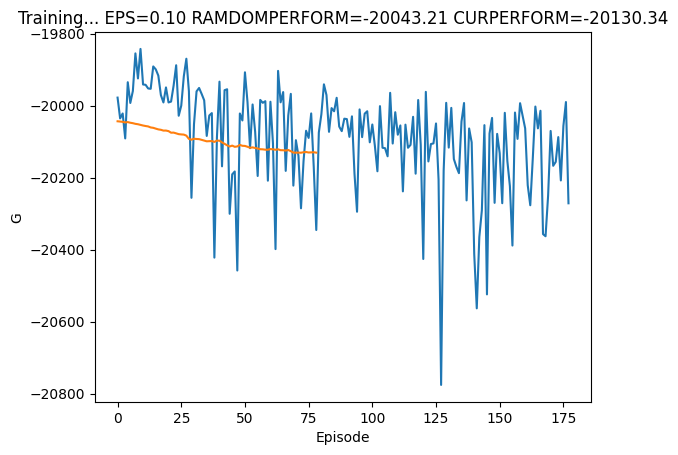

<Figure size 640x480 with 0 Axes>

In [9]:
num_episodes=114514

agent=Agent(5,5)

actionShuffle=[0,3,4,1,2]

for i_episode in range(num_episodes):
        start_weather, radius = start_state[2], start_state[3]

    #for agent in [group1]:#, group2, group3, group4, group5, group6, group7, group8, group9]:
        state = env.reset() 
        state_tensor=torch.tensor(stringStateToIntState(state),dtype=torch.float32,device=device).unsqueeze(0)
        env.cur_weather = start_weather   # assert common start weather
        env.radius = radius               # assert common track radius
        done = False
        G = 0
        i = 0
        t=0

        reward_per_lap=[]
        while True:
            env.cur_weather = holder[i]   # assert weather transition

            action_tensor=agent.select_action(state_tensor)

            #print("cur_weather:{},action:{}".format(env.cur_weather,action_tensor.item()))
            reward,next_state,terminated,velocity=env.transition(actionShuffle[action_tensor.item()])
            #print(action_tensor.item())
            #print(reward)

            done=terminated
            reward_per_lap.append(reward)
            converted_reward=reward
            

            reward_tensor=torch.tensor([converted_reward],device=device)
            done=terminated

            # added velocity for sanity check
            G += reward
            i += 1

            if terminated:
                next_state_tensor=None
            else:
                next_state_tensor=torch.tensor(stringStateToIntState(next_state),dtype=torch.float32,device=device).unsqueeze(0)

            agent.memory.push(state_tensor,action_tensor,next_state_tensor,reward_tensor)

            state = deepcopy(next_state)
            state_tensor=torch.tensor(stringStateToIntState(state),dtype=torch.float32,device=device).unsqueeze(0)

            agent.optimize_model()
            target_net_state_dict = agent.target_net.state_dict()
            policy_net_state_dict = agent.policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*agent.TAU + target_net_state_dict[key]*(1-agent.TAU)
            agent.target_net.load_state_dict(target_net_state_dict)

            if done:
                agent.episode_G.append(G)
                if i_episode%1==0:agent.plot_durations()
                break
            
        
        #print("G: %.2f" % G)

print('Complete')
group1.plot_durations(show_result=True)
plt.ioff()
plt.show()
        

